<a href="https://colab.research.google.com/github/nordm031/machine_learning_mammography/blob/main/EE_8591_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Setup And Initialization

In [ ]:
import os

import numba
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv

from time import time
from numba import cuda
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import display
from skimage.feature import hog
from skimage.color import rgb2grey
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [ ]:
# Mounting Google Drive to Access Datasets

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Resizing Images
import shutil
dirname = '/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_ben'
size = 175, 175
for fname in os.listdir(dirname):
    im = Image.open(os.path.join(dirname, fname))
    im.thumbnail(size, Image.ANTIALIAS)
    im.save(fname)
    shutil.copy(("/content/" + fname), os.path.join("/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_ben_resized", fname))

dirname = '/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_mal'
size = 175, 175
for fname in os.listdir(dirname):
    im = Image.open(os.path.join(dirname, fname))
    im.thumbnail(size, Image.ANTIALIAS)
    im.save(fname)
    shutil.copy(("/content/" + fname), os.path.join("/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_mal_resized", fname))



# Block of Helper Functions

Below are functions used throughout the problem

In [ ]:
# Block of Helper Functions

# Function to load images from Google Drive and convert to numpy array
def load_files(dirname):
  final = []
  for fname in os.listdir(dirname):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    final.append(imarray)
  return np.asarray(final)


# Function to create features for images and flattening into a single row
def create_features(img):
  color_features = img.flatten()
  #grey_img = rgb2grey(img)
  #hog_features = hog(grey_img, block_norm = 'L2-Hys', pixels_per_cell = (16, 16))
  flattened_features = np.hstack(color_features)
  return flattened_features


# Function to loop over all images in the dataset to form feature matrix
def create_feature_matrix(data):
  N = data.shape[0]
  features_list = []

  for i in range(0,N):
    image_features = create_features(data[i])
    features_list.append(image_features)
  
  feature_matrix = np.array(features_list)
  return feature_matrix

In [ ]:
# Loading Patches Based On Class (Benign = ben, Malignant = mal, Negative = neg)

dirname = '/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_ben_resized'
ben_patches_original = load_files(dirname)

dirname = '/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_mal_resized'
mal_patches_original = load_files(dirname)

#dirname = '/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_neg'
#neg_patches = load_files(dirname)

In [ ]:
# Saving numpy arrays to speed up future work and avoid reloading the image files
np.save("ben_patches_resized.npy", ben_patches_original)
np.save("mal_patches_resized.npy", mal_patches_original)

files.download("ben_patches_resized.npy")
files.download("mal_patches_resized.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Loading Saved numpy arrays

ben_patches_original = np.load('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/Class_original_numpy_matrices_npy/ben_patches_resized.npy')
mal_patches_original = np.load('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/Class_original_numpy_matrices_npy/mal_patches_resized.npy')


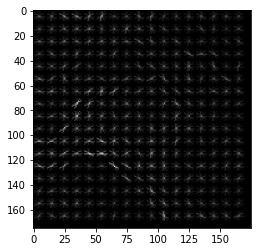

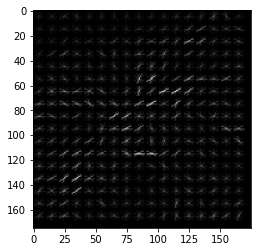

In [ ]:
# Running HOG using greyscaled images (to generate test images for report)

hog_test_image_ben = rgb2grey(ben_patches_original)
hog_test_image_mal = rgb2grey(mal_patches_original)

hog_features_ben, hog_image_ben = hog(hog_test_image_ben[20], orientations = 9, visualize=True, block_norm = 'L2-Hys', pixels_per_cell = (10, 10), cells_per_block=(2, 2))



plt.figure(1)
plt.imshow(hog_image_ben, cmap=mpl.cm.gray)
plt.figure(2)
plt.imshow(hog_image_mal, cmap=mpl.cm.gray)

In [ ]:
# Adding Class Labels and Separting Into Training and Testing Sets (0 = benign, 1 = malignant)

# Creating Feature Matrix for Each Class
mal_feature_matrix = create_feature_matrix(mal_patches_original)
ben_feature_matrix = create_feature_matrix(ben_patches_original)

In [ ]:
# Creating Class Labels (Stacking mal class (1) on top of ben class (0))
y = np.vstack((np.ones((mal_feature_matrix.shape[0], 1)), np.zeros((ben_feature_matrix.shape[0], 1))))

In [ ]:
# Saving numpy arrays to speed up future work and avoid reloading the image files
#np.save("mal_feature_matrix_resized.npy", mal_feature_matrix)
#np.save("ben_feature_matrix_resized.npy", ben_feature_matrix)

#files.download("mal_feature_matrix_resized.npy")
#files.download("ben_feature_matrix_resized.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Loading Feature Matrices
#mal_feature_matrix = np.load('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_feature_matrices_npy/mal_feature_matrix_resized.npy')
#ben_feature_matrix = np.load('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_feature_matrices_npy/ben_feature_matrix_resized.npy')

In [ ]:
# Combining Feature Matrices and Splitting Into Training Set and Test Set
X = np.vstack((mal_feature_matrix, ben_feature_matrix))

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=.25, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.75, random_state=69)

print("X_Train Dimension: " + str(X_train.shape))
print("X_Test Dimension: " + str(X_test.shape))
print("y_train Dimension: " + str(y_train.shape))
print("y_Test Dimension: " + str(y_test.shape))

X_Train Dimension: (1233, 91875)
X_Test Dimension: (411, 91875)
y_train Dimension: (1233, 1)
y_Test Dimension: (411, 1)


In [ ]:
# Scaling and reducing feature dimensionality in order to be used with SVM.

print("Original Training Dimension: " + str(X_train.shape))

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)

N_mal = X_train.shape[0]
N = 200 #Further Reduced Dimensionality Test

pca = PCA(n_components=N, svd_solver='randomized', whiten=True)
X_train_PCA = pca.fit_transform(X_train_ss)

print("New Training Dimension After PCA: " + str(X_train_PCA.shape))

Original Training Dimension: (1233, 91875)
New Training Dimension After PCA: (1233, 200)


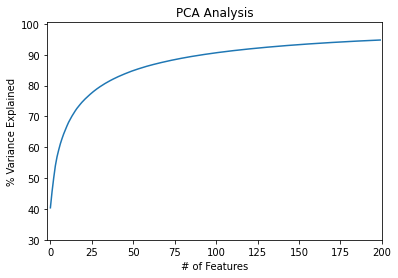

In [ ]:
# Determining Explained Variance Per Number of Features Kept

variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=10)*100)
var #cumulative sum of variance explained with [n] features

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.xlim(-2, 200)
plt.style.context('seaborn-whitegrid')


plt.figure(1)
plt.plot(var)

In [ ]:
print(np.cumsum(np.round(pca.explained_variance_ratio_[0:200], decimals=10)*100))

[40.37505311 45.60220808 50.04897844 54.00659787 56.89914231 59.1053496
 61.11021177 62.77832237 64.29828774 65.63855831 66.91992822 68.1178775
 69.11521285 70.0906725  70.98394775 71.8138783  72.59738119 73.28062568
 73.93557038 74.56857235 75.14465082 75.69035636 76.20216948 76.69653013
 77.1809643  77.64495474 78.08742503 78.50955179 78.91204675 79.2965874
 79.66076531 80.01314029 80.35440434 80.68345106 80.99362529 81.29890906
 81.5907252  81.8803187  82.14454105 82.40790676 82.66372934 82.91713336
 83.15542333 83.3872283  83.61500622 83.83669883 84.0543074  84.26552264
 84.47323222 84.678825   84.86967856 85.05786713 85.23620856 85.41095186
 85.58382034 85.75275054 85.91818796 86.08153193 86.23883021 86.39073855
 86.53910596 86.68101042 86.82137296 86.96027864 87.09379186 87.22636298
 87.35623785 87.48353289 87.60921802 87.73232135 87.85450552 87.97465152
 88.08964371 88.20301201 88.31523101 88.42517797 88.53297754 88.63894571
 88.74263142 88.84496411 88.94592618 89.04515438 89.14

In [ ]:
# Performing SVC Training and Training Set
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [0.01, 0.1, 1, 10, 1e3, 1e4],'gamma': [1e-3, 1e-2, 1e-1, 1e0], 'degree': [1, 2, 3]}
clf = GridSearchCV(SVC(kernel='p
oly'), param_grid)
y_train = np.ravel(y_train)
clf = clf.fit(X_train_PCA, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


In [ ]:
clf.cv_results_["mean_test_score"].mean()

0.6307819854514335

In [ ]:
# Evaluating Model On Test Data
X_test_PCA = pca.transform(X_test)

print("Performing Prediction")
t0 = time()
y_pred = clf.predict(X_test_PCA)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
print(confusion_matrix(y_test, y_pred, labels=range(2)))

accuracy_score(y_test,y_pred)


Performing Prediction
done in 0.133s
              precision    recall  f1-score   support

      Benign       0.94      0.68      0.79       235
   Malignant       0.68      0.94      0.79       176

    accuracy                           0.79       411
   macro avg       0.81      0.81      0.79       411
weighted avg       0.83      0.79      0.79       411

[[159  76]
 [ 11 165]]


0.7883211678832117

(256, 256)


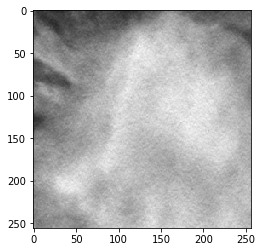

In [ ]:

im = Image.open('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_mal/DBT-P00107_DBT-S05365_lmlo_cancerpatch_-1.tif')
image = cv2.imread('/content/gdrive/MyDrive/PhD Program/Fall 2021/EE 8591/Course Project/class_mal/DBT-P00107_DBT-S05365_lmlo_cancerpatch_-1.tif', cv2.IMREAD_UNCHANGED)
print(im.size)
imarray = np.array(im)
imarray

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

#visualize(image)


plt.imshow(imarray, interpolation='nearest')
plt.show()


In [ ]:
# Deep Learning Model
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow import keras

# Build Keras Model
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100,
    decay_rate=.99)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

model.fit(X_train, y_train, epochs=500, batch_size=200, verbose=1)

model.evaluate(X_test, y_test)

Epoch 1/500
7/7 [==============================] - 1s 25ms/step - loss: 77859.3516 - accuracy: 0.4793
Epoch 2/500
7/7 [==============================] - 0s 23ms/step - loss: 10635.9316 - accuracy: 0.5710
Epoch 3/500
7/7 [==============================] - 0s 22ms/step - loss: 12903.4893 - accuracy: 0.5312
Epoch 4/500
7/7 [==============================] - 0s 21ms/step - loss: 8572.9785 - accuracy: 0.5523
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 7410.0981 - accuracy: 0.5458
Epoch 6/500
7/7 [==============================] - 0s 21ms/step - loss: 7013.3911 - accuracy: 0.5531
Epoch 7/500
7/7 [==============================] - 0s 21ms/step - loss: 4432.1890 - accuracy: 0.5977
Epoch 8/500
7/7 [==============================] - 0s 20ms/step - loss: 2406.6262 - accuracy: 0.6334
Epoch 9/500
7/7 [==============================] - 0s 21ms/step - loss: 1001.8327 - accuracy: 0.6586
Epoch 10/500
7/7 [==============================] - 0s 20ms/step - loss: 965.4818 - accu

[7.158005237579346, 0.7469586133956909]